In [2]:
from glob import glob
import json

import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 200)

In [3]:
snips_files_train = glob('../data/snips/2017-06-custom-intent-engines/*/train*full.json')
snips_files_test = glob('../data/snips/2017-06-custom-intent-engines/*/validate*.json')

In [4]:
def snips2top(snips_example, intent):
    """Convert Snips format to TOP format
    
    Args:
        snips_example: dict, one example following snips example format
        intent: str

    Returns:
        query_text, top_format_schema
    """
    query_text = ''
    top_format_str = f'[IN:{intent.upper()}'

    for text_chunk in snips_example:
        text = text_chunk["text"].strip(' ')

        if "entity" in text_chunk:
            entity_name = text_chunk["entity"].upper()
            top_format_str += f" [SL:{entity_name} {text} ]"

        else:
            top_format_str += ' ' + text

        query_text += ' ' + text

    query_text = query_text.strip(' ')
    top_format_str += " ]"

    return query_text, top_format_str


ex1 = [
    {'text': 'What will the weather be '},
    {'text': 'this year', 'entity': 'timeRange'},
    {'text': ' in '},
    {'text': 'Horseshoe Lake State Fish and Wildlife Area',
     'entity': 'geographic_poi'},
    {'text': '?'}
]
intent1 = 'GetWeather'
expected_out = ("What will the weather be this year in Horseshoe Lake State Fish and Wildlife Area ?", "[IN:GETWEATHER What will the weather be [SL:TIMERANGE this year ] in [SL:GEOGRAPHIC_POI Horseshoe Lake State Fish and Wildlife Area ] ? ]")
out = snips2top(ex1, intent1)
assert out == expected_out, out


def make_snips_df(snips_files):
    snips_data = []
    for train_file in snips_files:
        with open(train_file, encoding='latin-1') as f:
            data = json.load(f)

        assert len(data.keys()) == 1, data.keys()
        intent = list(data.keys())[0]
        print(f'Intent: {intent}, n examples: {len(data[intent])}')

        for example in data[intent]:
            assert len(example.keys()) == 1
            text, schema = snips2top(example['data'], intent)
            snips_data.append([text, text, schema])
    
    snips_df = pd.DataFrame(snips_data, columns=['text', 'tokens', 'schema'])
    return snips_df

print('Processing train')
snips_trainval = make_snips_df(glob('../data/snips/2017-06-custom-intent-engines/*/train*full.json'))
print()
print('Processing test')
snips_test = make_snips_df(glob('../data/snips/2017-06-custom-intent-engines/*/validate*.json'))

Processing train
Intent: PlayMusic, n examples: 2000
Intent: RateBook, n examples: 1956
Intent: SearchCreativeWork, n examples: 1954
Intent: GetWeather, n examples: 2000
Intent: BookRestaurant, n examples: 1973
Intent: AddToPlaylist, n examples: 1942
Intent: SearchScreeningEvent, n examples: 1959

Processing test
Intent: PlayMusic, n examples: 100
Intent: RateBook, n examples: 100
Intent: SearchCreativeWork, n examples: 100
Intent: GetWeather, n examples: 100
Intent: BookRestaurant, n examples: 100
Intent: AddToPlaylist, n examples: 100
Intent: SearchScreeningEvent, n examples: 100


In [5]:
permutation = np.random.permutation(len(snips_trainval))
train_subset_ids = permutation[700:]
valid_subset_ids = permutation[:700]

snips_train = snips_trainval.iloc[train_subset_ids]
snips_valid = snips_trainval.iloc[valid_subset_ids]

print('Train dataset len: ', len(snips_train))
print('Valid dataset len: ', len(snips_valid))
print('Test  dataset len: ', len(snips_test))

Train dataset len:  13084
Valid dataset len:  700
Test  dataset len:  700


In [11]:
# import os
# from os.path import join as path_join

# snips_path = path_join('snips', 'top_format')
# os.makedirs(snips_path)

# snips_train.to_csv(os.path.join(snips_path, 'train.tsv'), sep='\t', index=False, header=False)
# snips_valid.to_csv(os.path.join(snips_path, 'eval.tsv'), sep='\t', index=False, header=False)
# snips_test.to_csv(os.path.join(snips_path, 'test.tsv'), sep='\t', index=False, header=False)

# More vis

In [6]:
def tokenize(text):
    tokenized = ""
    for char in text:
        if char in ["[", "]"]:
            char = " " + char + " "
        if char in [":"]:
            char = char + " "
        tokenized += char
    tokens = tokenized.strip(" ").split(" ")
    tokens = [t for t in tokens if t != ""]
    return tokens

def top_schema_get_vocab(text):
    text = text.replace('[', '')
    text = text.replace(']', '')

    schema_tokens = {'[', ']', 'IN:', 'SL:'}

    for token in text.split(' '):
        if token[:3] in ['IN:', 'SL:']:
            schema_tokens.add(token[3:])
    return schema_tokens


In [7]:
vocab = set()

for i, line in snips_train.iterrows():
    _vocab = top_schema_get_vocab(line.schema)
    vocab = vocab.union(_vocab)

In [12]:
from collections import Counter
from tqdm.auto import tqdm

# to distinguish between slots and intents
extended_vocab = {'SL:' + token for token in vocab}.union({'IN:' + token for token in vocab})

frequencies = Counter()

for schema_str in tqdm(snips_train.schema, total=len(snips_train.schema)):
    for token in extended_vocab:
        if token in schema_str:
            frequencies[token] += 1

vocab = set(frequencies.keys())

<BarContainer object of 46 artists>

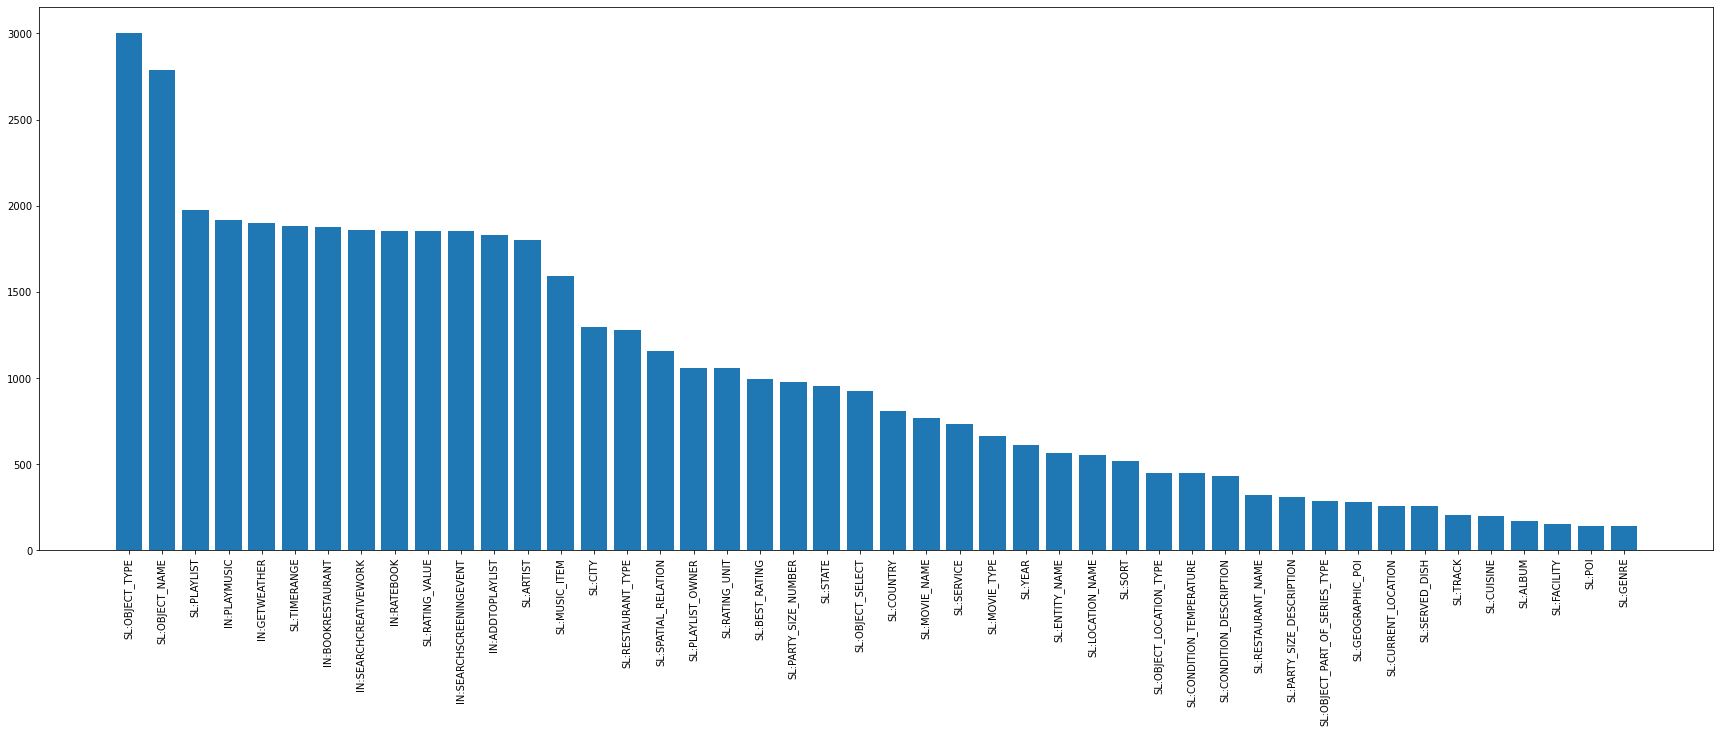

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))
labels, values = zip(*frequencies.most_common())
plt.xticks(rotation='vertical')
plt.bar(labels, values)

In [21]:
sorted(frequencies.items(), key=lambda x: x[1])

[('SL:POI', 139),
 ('SL:GENRE', 139),
 ('SL:FACILITY', 151),
 ('SL:ALBUM', 171),
 ('SL:CUISINE', 200),
 ('SL:TRACK', 204),
 ('SL:SERVED_DISH', 255),
 ('SL:CURRENT_LOCATION', 256),
 ('SL:GEOGRAPHIC_POI', 278),
 ('SL:OBJECT_PART_OF_SERIES_TYPE', 284),
 ('SL:PARTY_SIZE_DESCRIPTION', 307),
 ('SL:RESTAURANT_NAME', 320),
 ('SL:CONDITION_DESCRIPTION', 434),
 ('SL:OBJECT_LOCATION_TYPE', 448),
 ('SL:CONDITION_TEMPERATURE', 448),
 ('SL:SORT', 519),
 ('SL:LOCATION_NAME', 552),
 ('SL:ENTITY_NAME', 563),
 ('SL:YEAR', 609),
 ('SL:MOVIE_TYPE', 661),
 ('SL:SERVICE', 734),
 ('SL:MOVIE_NAME', 769),
 ('SL:COUNTRY', 811),
 ('SL:OBJECT_SELECT', 927),
 ('SL:STATE', 955),
 ('SL:PARTY_SIZE_NUMBER', 976),
 ('SL:BEST_RATING', 994),
 ('SL:PLAYLIST_OWNER', 1060),
 ('SL:RATING_UNIT', 1060),
 ('SL:SPATIAL_RELATION', 1156),
 ('SL:RESTAURANT_TYPE', 1279),
 ('SL:CITY', 1299),
 ('SL:MUSIC_ITEM', 1591),
 ('SL:ARTIST', 1801),
 ('IN:ADDTOPLAYLIST', 1830),
 ('IN:SEARCHSCREENINGEVENT', 1851),
 ('IN:RATEBOOK', 1852),
 ('SL:R

In [24]:
255 * 0.90

229.5

In [25]:
255 * 0.1

25.5